<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Loading data into a Pyleoclim Series

## Authors

## Preamble
The object at the heart of the package is the [`Series` object](https://pyleoclim-util.readthedocs
.io/en/master/core/ui.html#series-pyleoclim-series), which describes the fundamentals of a time series. To create a
Pyleoclim `Series`, we first need to load the data set, and then specify values for its various properties:

* `time`: Time values for the time series
* `value`: Paleo values for the time series
* `time_name` (optional): Name of the time vector, (e.g., 'Time', 'Age'). This is used to label the x-axis on plots
* `time_unit` (optional): The units of the time axis (e.g., 'years')
* `value_name` (optional): The name of the paleo variable (e.g., 'Temperature')
* `value_unit` (optional): The units of the paleo variable (e.g., 'deg C')
* `label` (optional): Name of the time series (e.g., 'Nino 3.4')
* `clean_ts` (optional): If True (default), remove NaNs and set an increasing time axis.

Data is stored in different file types, which may need to be ingested in different ways.  Here we present examples of
 how to wrangle CSV, NetCDF, and LiPD files.

### Goals:
* Create Pyleoclim Series from datasets stored as CSV, NetCDF, and LiPD files
**Reading Time:**

### Keywords

CSV; NetCDF; LiPD, Series; EnsembleSeries

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Pandas; Xarray

## Data Description

[Crystal cave record](https://doi.org/10.1038/ngeo1862): McCabe-Glynn, S., Johnson, K., Strong, C. et al. Variable
North Pacific influence on drought in southwestern North America since AD 854. Nature Geosci 6, 617–621 (2013).

## Code
### Import packages

In [3]:
import pyleoclim as pyleo

### LiPD
Linked Paleo Data format ([LiPD](http://www.clim-past-discuss.net/11/4309/2015/cpd-11-4309-2015-discussion.html)) files contain time series information in addition to supporting metadata (e.g., root metadata, location).
Pyleoclim leverages this additional information using LiPD-specific functionality discussed in greater depth in [this
 tutorial]().

Data stored in the `.lpd` format can be loaded directly into Pyleoclim as a
[Lipd object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html?highlight=lipd#pyleoclim.core.lipd.Lipd).
If the data_path points to one LiPD file, `pyleo.Lipd` will load the specific record, while if data_path points to a
folder of lipd files, `pyleo.Lipd` will load the full set of records.

##### Loading a single LiPD file

In [82]:
data_path = 'data/lipd/Crystal.McCabe-Glynn.2013.lpd'
d = pyleo.Lipd(data_path)

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Crystal.McCabe-Glynn.2013.lpd
1.42 MB :That's a big file! This may take a while to load...
Finished read: 1 record


As a check to make sure the LiPD file corresponds to the expected record, we can quickly generate a map that
indicates the location.

(<Figure size 432x288 with 1 Axes>, <GeoAxesSubplot:>)

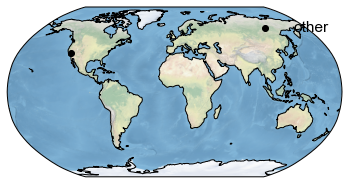

In [89]:
d.mapAllArchive()

##### Loading multiple LiPD files

In [90]:
data_path = 'data/lipd'
d_multiple = pyleo.Lipd(data_path)


Disclaimer: LiPD files may be updated and modified to adhere to standards

Found: 2 LiPD file(s)
reading: Crystal.McCabe-Glynn.2013.lpd
1.42 MB :That's a big file! This may take a while to load...
reading: MD98-2170.Stott.2004.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Finished read: 2 records


(<Figure size 432x288 with 1 Axes>, <GeoAxesSubplot:>)

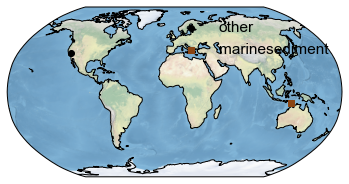

In [91]:
d_multiple.mapAllArchive()

### NetCDF
In order to load data from a NetCDF file, we will use [Xarray](https://docs.xarray.dev/en/stable/index.html).

In [2]:
import xarray as xr

In [6]:
file_path = 'data/p2k_ngeo19_recons.nc'
p2k_nc = xr.open_dataset(file_path)

The coordinates of this data set are `year` and `ens`, and the temperature anamoly is contained in the variable
`LMRv2.1`. Below we extract the timeseries for one ensemble run:

In [38]:
ens_run1 = [p2k_nc.data_vars['LMRv2.1'][ik][0] for ik in range(len(p2k_nc.year))]

To create the `pyleo.Series`, we pass the time coordinate of the dataset, `p2k_nc.year`, as `time`, and `ens_run1`
(extracted from the `p2k_nc` dataset) as `value`. It is optional to specify `time_name` and `time_unit`, and
`value_name` and `value_unit`, but doing so ensures that plot axes are properly labeled.

In [49]:
p2k_ps = pyleo.Series(time=p2k_nc.year, value=ens_run1,
                      time_name='Time', time_unit='year',
                      value_name='Temperature anomaly', value_unit='$^{\circ}$C')

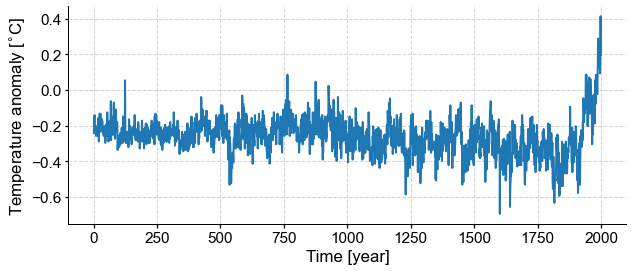

In [51]:
fig, ax = p2k_ps.plot()

However, given this is an ensemble, capturing this data in a `pyleo.EnsembleSeries` will open up opportunities for
specific analysis and visualization. In the cell below, we generate a list of `pyleo.Series` (one for each trace) for
the full set of ensemble runs in much the same way as above.

In [78]:
ts_list = []

for im in range(len(p2k_nc.ens)):
    ens_run = [p2k_nc.data_vars['LMRv2.1'][ik][im] for ik in range(len(p2k_nc.year))]
    ts_list.append(pyleo.Series(time=p2k_nc.year, value=ens_run,
                      time_name='Time', time_unit='year',
                      value_name='Temperature anomaly', value_unit='$^{\circ}$C'))


Then we simply pass `ts_list` to `pyleo.EnsembleSeries`...

In [79]:
ts_ens = pyleo.EnsembleSeries(ts_list)

For more detail on visualizing `pyleo.EnsembleSeries`, check out the tutorial on [Basic operations with
MultipleSeries and EnsembleSeries](), but we can use `plot_traces()` to quickly check to make sure the data seems
properly organized (by default, `plot_traces()` plots 10 randomly selected traces).

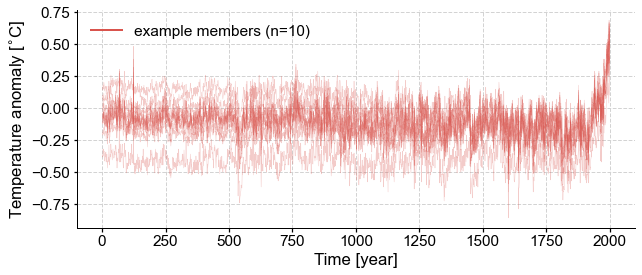

In [80]:
fig, ax = ts_ens.plot_traces()

### CSV
CSV files have a table structure, so we will use [Pandas]() and the read the data into a pandas `DataFrame`.

In [52]:
import pandas as pd

In [67]:
file_path  = 'data/LR04.csv'
LRO4_data = pd.read_csv(file_path, header=2)

To create a `pyleo.Series`, we pass the `Time (ka)` column as `time` and the `Benthic d18O (per mil)` column as `value`.

In [71]:
LR04_ps = pyleo.Series(time=LRO4_data['Time (ka)'], value=LRO4_data['Benthic d18O (per mil)  '],
                      time_name='Time', time_unit='ka',
                      value_name='$\delta^{18}$O', value_unit='per mil')

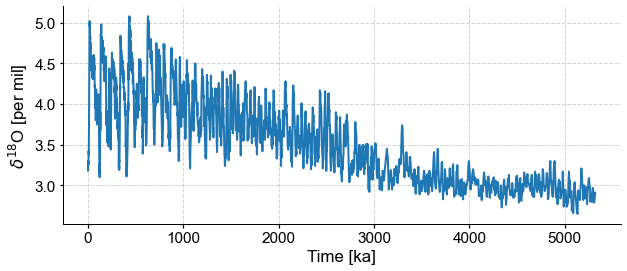

In [74]:
fig, ax = LR04_ps.plot()